### Import packages 

In [59]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import warnings
warnings.filterwarnings('ignore')

The "XOR" (or "exclusive OR") problem is often used to illustrate the ability of neural networks to fit complicated functions. The XOR problem has a checkerboard structure:

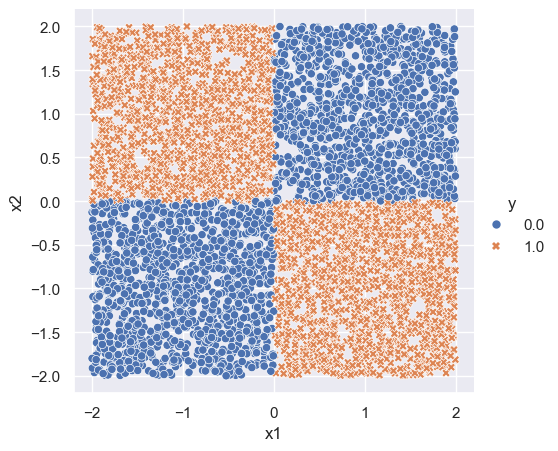

In [60]:
# xor ------------------------------------
n = 5000
p = 2
x = np.random.uniform(-2, 2, size=(n, p))

#x[,1] <- first column (R)
#x[:, 0] <- first column (Python)

y = ((x[:,0] < 0) & (x[:, 1] > 0)).astype(x.dtype) + ((x[:,0] > 0) & (x[:, 1] < 0)).astype(x.dtype)

df = np.hstack([y.reshape((n, 1)), x])
df = pd.DataFrame(df, columns = ['y', 'x1', 'x2'])

sns.set_theme()
xor_plot = sns.relplot(df, x='x1', y='x2', hue='y', style='y')
xor_plot.figure.subplots_adjust(top=.9)

Logistic regression can only fit linear decision boundaries, and so fails the XOR problem.

(-2.0, 2.0)

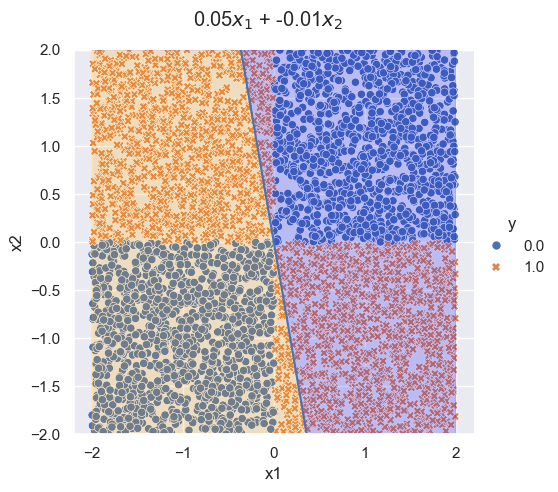

In [61]:
## logitstic regression doesn't work
log_fit = LogisticRegression()
log_fit.fit(x, y)
coeffs = log_fit.coef_[0]
coeff = -coeffs[0]/coeffs[1]

## plot
logit_plot = sns.relplot(df, x='x1', y='x2', hue='y', style='y')
plt.axline([0,0], slope=coeff)
## title
logit_plot.figure.subplots_adjust(top=.9)
logit_plot.figure.suptitle(str(round(coeffs[0], 2)) + r'$x_1$ + ' + str(round(-coeffs[1], 2)) + r'$x_2$')
## fill in area
x_fill = np.linspace(-2, 2, num=200)
y_line = coeff * x_fill
logit_plot.ax.fill_between(x_fill, y_line, 2, color='blue', alpha=0.2)
logit_plot.ax.fill_between(x_fill, -2, y_line, color='orange', alpha=0.2)
logit_plot.ax.set_ylim(-2,2)

## Neural networks

Let's set up a 1-layer neural network to solve the XOR problem.

For deep learning, we use the `torch` package, available [here](https://pytorch.org).

### Neural network classes in PyTorch

`torch` provides a base class called `nn.Module`. 

When we set up a neural network, we sub-class `nn.Module`.

Here is an example of a neural network in `torch` named `XORNet`.

In [62]:
class XORNet(nn.Module):

    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid())

    def forward(self, x):
        y = self.sequential(x)
        y = torch.flatten(y)
        return y

    def loss_fn(self, y, y_pred):
        loss = y * torch.log(y_pred + 1e-8) + (1-y) * torch.log(1-y_pred + 1e-8)
        output = -loss.sum()
        return output

The `class` statement identifies the code chunk as a declaration for a class `XORNet` that inherits from the base class `nn.Module`. This base class is ubiquitous in torch and represents the mappings in the neural networks.

Indented beneath the class statement are the methods of this class: in this case `__init__`, `forward` and `loss_fn`. The `__init__` method is called when an instance of the class is created. In the methods, self always refers to an instance of the class. In the `__init__` method, we have attached an object to self as an attribute: sequential, that defines the neural network architecture.

There is one additional line in the `__init__` method, which is a call to `super()`. This function allows subclasses (i.e. `XORNet`) to access methods of the class they inherit from. For example, the class `nn.Module` has its own `__init__` method, which is different from the `XORNet.__init__()` method we’ve written above. Using `super()` allows us to call the method of the base class. For torch models, we will always be making this `super()` call as it is necessary for the model to be properly interpreted by torch.

The function `forward` is called when the neural network is run on input data.

(Above explanation adapted from [ISLP labs](https://github.com/intro-stat-learning/ISLP_labs/blob/stable/Ch10-deeplearning-lab.ipynb))

In [63]:
hidden_dim=2
model = XORNet(input_dim=p, hidden_dim=hidden_dim)

In [64]:
model

XORNet(
  (sequential): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=2, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

### Data
For torch to read the data, it needs to be a `torch.tensor` type:

In [65]:
x_train = torch.tensor(x, dtype=torch.float)
y_train = torch.tensor(y, dtype=torch.float)

We combine `x_train` and `y_train` into a `TensorDataset`, a dataset recognizable by torch. `TensorDataset` stores the samples and their labels. It is a subclass of the more general `torch.utils.data.Dataset`, which you can customize for non-standard data.

In [66]:
train_data = TensorDataset(x_train, y_train)

`TensorDataset` is helpful as it can be passed to `DataLoader()`. `DataLoader` wraps an iterable around the `Dataset` class to enable easy access to the samples. This is very helpful for implementing stochastic gradient descent, where we iterate over subsets (batches) of the data.

In [67]:
train_loader = DataLoader(dataset=train_data, batch_size=10, shuffle=True)

### Training
We now set up the optimizer for training. We use Adam, and a base learning rate of `lr=0.01`. We set the number of epochs to 100. (Rule of thumb: pick largest `lr` that still results in convergence)

In [68]:
lr = 0.01
epochs = 100

optimizer = optim.Adam(model.parameters(), lr=lr)

# set model to training mode
model.train()

XORNet(
  (sequential): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=2, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

Now we train the model:

In [69]:
for epoch in range(epochs):
    
    # in each epoch, iterate over all batches of data (easily accessed through train_loader)
    l = 0

    for x_batch, y_batch in train_loader:

        pred = model(x_batch)                   # this is the output from the forward function
        loss = model.loss_fn(y_batch, pred)     # calculate loss function

        loss.backward()                         # computes gradients wrt loss function
        optimizer.step()                        # updates parameters 
        optimizer.zero_grad()                   # set the gradients back to zero (otherwise grads are accumulated)

        l += loss.item()

    if epoch % 10 == 0:
        print('epoch: ', epoch, 'loss:', f"{l:.3}")


epoch:  0 loss: 3.43e+03
epoch:  10 loss: 1.92e+03
epoch:  20 loss: 1.9e+03
epoch:  30 loss: 1.89e+03
epoch:  40 loss: 1.89e+03
epoch:  50 loss: 1.88e+03
epoch:  60 loss: 1.88e+03
epoch:  70 loss: 1.88e+03
epoch:  80 loss: 1.88e+03
epoch:  90 loss: 1.88e+03


To visualize the end result, we plot the predicted values over the whole space (the decision surface).

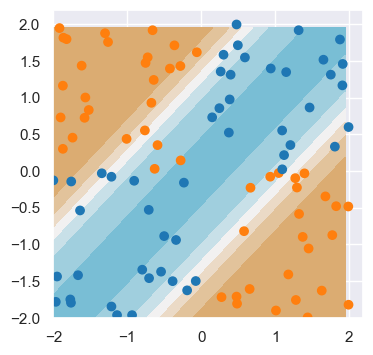

In [70]:
x1 = np.arange(-2, 2, 0.05)
x2 = np.arange(-2, 2, 0.05)

x_test_np = np.array([(i, j) for i in x1 for j in x2])
y_test_np = ((x_test_np[:,0] < 0) & (x_test_np[:, 1] > 0)).astype(x_test_np.dtype) + ((x_test_np[:,0] > 0) & (x_test_np[:, 1] < 0)).astype(x_test_np.dtype)

x_test = torch.tensor(x_test_np, dtype=torch.float)
y_test = torch.tensor(y_test_np)


model.eval()
y_pred = model(x_test)

y_pred_np = y_pred.detach().numpy()
y_pred_np = y_pred_np.reshape(x1.shape[0], x2.shape[0])

seaborn_cols = sns.color_palette("tab10")
cols = [seaborn_cols[int(i)] for i in y]

custom_cmap = sns.diverging_palette(220, 50, s=70, l=70, as_cmap=True)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.contourf(x1, x2, y_pred_np, cmap=custom_cmap)
ax.scatter(x[0:100,0], x[0:100,1], c=cols[0:100])

In [71]:
model.sequential[0].weight

Parameter containing:
tensor([[ 1.9588, -2.0800],
        [ 1.8403, -1.9693]], requires_grad=True)

In [72]:
model.sequential[0].bias

Parameter containing:
tensor([ 3.2469, -3.4566], requires_grad=True)

In [73]:
model.sequential[2].weight

Parameter containing:
tensor([[-7.8841, 10.4450]], requires_grad=True)

Play around with different sizes of `hidden_dim` and see the difference!

In [74]:
model.sequential[2].bias

Parameter containing:
tensor([5.2895], requires_grad=True)

## MNIST example

We use `torchvision.datasets` to download the MNIST data.

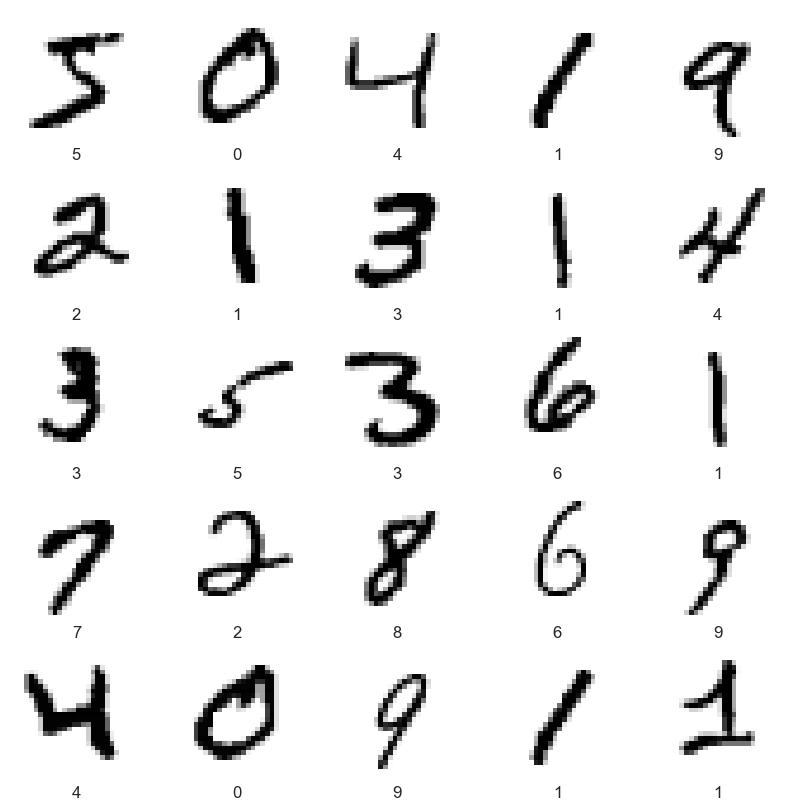

In [75]:
(mnist_train,
 mnist_test) = [torchvision.datasets.MNIST(root='data',
                      train=train,
                      download=True,
                      transform=torchvision.transforms.ToTensor())
                for train in [True, False]]

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    train_image, label = mnist_train[i]
    plt.imshow(train_image[0], cmap=plt.cm.binary)
    plt.xlabel(label)
plt.show()

Set up our dataloaders.

In [76]:
train_loader = DataLoader(dataset=mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=mnist_test, batch_size=10000, shuffle=False)

Let's define our neural network for the MNIST classification problem.

In [77]:
class MNISTNet(nn.Module):

    def __init__(self):
        super(MNISTNet, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Softmax()
        )

    def forward(self, x):
        prob = self.layers(x)
        return prob

    def loss_fn(self, y, y_pred):
        log_pred = torch.log(y_pred + 1e-8)
        loss = -(log_pred * y).sum(1).mean()
        return loss

Instantiate our model:

In [78]:
model = MNISTNet()

Train our model:

In [79]:
lr = 0.001
epochs = 50

optimizer = optim.Adam(model.parameters(), lr=lr)

# set model to training mode
model.train()

for epoch in range(epochs):
    l = 0
    for x_batch, y_batch in train_loader:

        x_batch = x_batch.reshape(x_batch.shape[0], 28*28)
        y_batch = F.one_hot(y_batch, num_classes=10)
        y_pred = model(x_batch)
        loss = model.loss_fn(y_batch, y_pred)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        l += loss.item()

    if epoch % 10 == 0:
        print('epoch: ', epoch, 'loss:', f"{l:.3}")

epoch:  0 loss: 2.63e+02
epoch:  10 loss: 12.6
epoch:  20 loss: 5.3
epoch:  30 loss: 6.31
epoch:  40 loss: 4.5


Calculate our accuracy:

In [80]:
model.eval()
x_batch, y_batch = next(iter(test_loader))
x_batch = x_batch.reshape(x_batch.shape[0], 28 * 28)
y_pred_array = model(x_batch)
y_pred = torch.argmax(y_pred_array, axis=1)
acc = (y_pred == y_batch).sum()
acc = acc / len(y_pred)

Let's look at some interesting results (code adapted from [here](https://github.com/probml/pyprobml/blob/master/notebooks/book1/13/mlp_mnist_tf.ipynb))

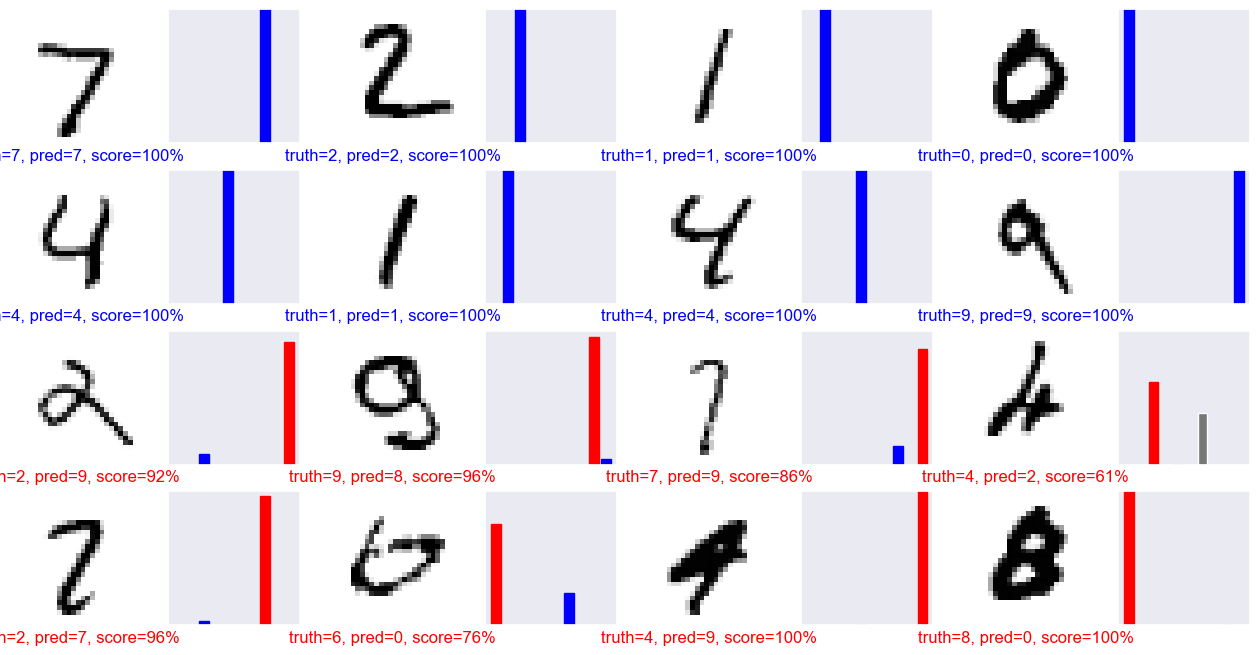

In [81]:
# find interesting test images
errors = torch.where(y_pred != y_batch)[0]
inds1 = range(8)
inds2 = errors[:8]
inds = np.concatenate((inds1, inds2))

pred_array = y_pred_array.detach().numpy()

num_rows = 4
num_cols = 4
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))

for i in range(num_images):
    n = inds[i]
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image, label = mnist_test[n]
    plt.imshow(image[0], cmap=plt.cm.binary)
    plt.xlabel(label)
    predicted_label = y_pred[n]
    if predicted_label == label:
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel("truth={}, pred={}, score={:2.0f}%".format(
        label,
        predicted_label,
        100 * np.max(pred_array[n])),
        color=color)

    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), pred_array[n], color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(pred_array[n])
    thisplot[predicted_label].set_color('red')
    thisplot[label].set_color('blue')

## Heteroskedastic regression

This code is adapted from [here](https://github.com/probml/pyprobml/blob/master/notebooks/book1/13/mlp_1d_regression_hetero_tfp.ipynb).

In [82]:
# Make data

x_range = [-20, 60]  # test
x_ranges = [[-20, 60]]
ns = [1000]

def load_dataset():
    def s(x):  # std of noise
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 0.25 + g**2.0

    x = []
    y = []
    for i in range(len(ns)):
        n = ns[i]
        xr = x_ranges[i]
        x1 = np.linspace(xr[0], xr[1], n)
        eps = np.random.randn(n) * s(x1)
        y1 = (1 * np.sin(0.2 * x1) + 0.1 * x1) + eps
        x = np.concatenate((x, x1))
        y = np.concatenate((y, y1))
    # print(x.shape)
    x = x[..., np.newaxis]
    n_test = 150
    x_test = np.linspace(*x_range, num=n_test).astype(np.float32)
    x_test = x_test[..., np.newaxis]
    return y, x, x_test

y, x, x_test = load_dataset()

Define neural network

In [83]:
class HetNet(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_dims, mean_dims, var_dims):
        super(HetNet, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dims
        self.mean_dims = mean_dims
        self.var_dims = var_dims

        # create backbone
        current_dim = input_dim
        self.layers = nn.ModuleList()
        for i in range(len(hidden_dims)):
            hdim = hidden_dims[i]
            self.layers.append(nn.Linear(current_dim, hdim))
            current_dim = hdim

        # create heads
        core_dim = hidden_dims[-1]
        current_dim = core_dim
        self.mean_layers = nn.ModuleList()
        for i in range(len(mean_dims)):
            hdim = mean_dims[i]
            self.mean_layers.append(nn.Linear(current_dim, hdim))
            current_dim = hdim
        self.mean_layers.append(nn.Linear(current_dim, output_dim))

        current_dim = core_dim
        self.var_layers = nn.ModuleList()
        for i in range(len(var_dims)):
            hdim = var_dims[i]
            self.var_layers.append(nn.Linear(current_dim, hdim))
            current_dim = hdim
        self.var_layers.append(nn.Linear(current_dim, output_dim))

    def core_net(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))
        return x

    def mean_net(self, x):
        for layer in self.mean_layers[:-1]:
            x = F.relu(layer(x))
        x = self.mean_layers[-1](x)
        return x

    def var_net(self, x):
        for layer in self.var_layers[:-1]:
            x = F.relu(layer(x))
        x = self.var_layers[-1](x)
        return x

    def forward(self, x):
        mean = self.mean_net(self.core_net(x))
        log_var = self.var_net(self.core_net(x))

        return mean, log_var

    def loss_fn(self, x, y):
        mean, log_var = self.forward(x)
        var = torch.exp(log_var)

        loss = torch.pow(y-mean, 2) / var + log_var
        out = loss.mean()

        return out

Set up data

In [84]:
x_train = torch.tensor(x, dtype=torch.float)
y_train = torch.tensor(y, dtype=torch.float)
y_train = y_train.unsqueeze(-1)

train_data = TensorDataset(x_train, y_train)
train_loader = DataLoader(dataset=train_data, batch_size=10, shuffle=True)

Initialize model

In [85]:
hidden_dims = [50, 50]
mean_dims = [20]
var_dims = [20]
model = HetNet(input_dim=1, output_dim=1, hidden_dims=hidden_dims, mean_dims=mean_dims, var_dims=var_dims)

Train

In [86]:
lr = 0.001
epochs = 500

optimizer = optim.Adam(model.parameters(), lr=lr)

# set model to training mode
model.train()

for epoch in range(epochs):

    l = 0
    for x_batch, y_batch in train_loader:

        loss = model.loss_fn(x_batch, y_batch)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        l += loss.item()

    if epoch % 50 == 0:
        print('epoch: ', epoch, 'loss:', f"{l:.3}")

epoch:  0 loss: 1.23e+02
epoch:  50 loss: -5.78
epoch:  100 loss: -17.2
epoch:  150 loss: -27.7
epoch:  200 loss: -27.3
epoch:  250 loss: -32.9
epoch:  300 loss: -33.2
epoch:  350 loss: -32.1
epoch:  400 loss: -32.4
epoch:  450 loss: -31.2


Plot results

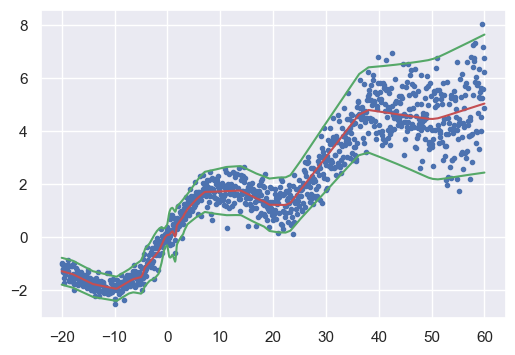

In [87]:
model.eval()
mean, log_var = model(x_train)
sd = torch.exp(0.5 * log_var)
mean_np = mean.detach().numpy()
sd_np = sd.detach().numpy()

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 4)
ax.plot(x, y, '.', label="observed")
ax.plot(x, mean_np, 'r-')
ax.plot(x, mean_np + 2 * sd_np, 'g-')
ax.plot(x, mean_np - 2 * sd_np, 'g-')